# Исследование жилой недвижимости г. Саратова

## Очистка и подготовка данных

### План действий:

1. + Получить полный список столбцов и их характеристики (тип и количество значений) и удалить лишние
2. + Удалить строки, в которых значение столбца 'Тип' пустое (=='')
3. + Объединить столбцы, которые несут одинаковую информацию если они есть
4. + Преобразовать числовые значения из строк в соответствующий числовой тип
5. + Разделить датасет на три - квартиры/комнаты, комнаты, дома/части домов
6. + Удалить лишний текст в столбцах где должны быть только числовые значения (с помощью регулярных выражений)
7. + Разделить столбец этаж/этажность на два соответствующих
8. Проверить датасеты на наличие повторений (по url)

In [170]:
import math
import matplotlib
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

### Загружаем датасет и смотрим его основные характеристики

In [172]:
raw_data = pd.read_json('living_realty_raw.json', orient='columns')

In [173]:
raw_data.head()

,url,Адрес,Балкон,Вторичное жилье,Высота потолков,Год постройки,Городской телефон,Дата сдачи,Дом(cтроение),Доп. информация,...,Санузел,Собственность,Создано,Стадия строительства,Тип,Торг,Цена,Цена за м²,Этаж/этажей в доме,Этажей
0,https://kvadrat64.ru/sellflat-499534.html,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",лоджия,NaN,"потолок 2,8 м",NaN,NaN,2017 год постройки,дом монолитно-каркасный,NaN,...,2 санузла,NaN,04-07-2018,дом сдан,3-х комнатная квартира,NaN,5 000 000,56 818,этаж 6/18,NaN
1,https://kvadrat64.ru/sellflat-499537.html,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",лоджия,NaN,"потолок 2,8 м",NaN,NaN,2017 год постройки,дом монолитно-каркасный,NaN,...,2 санузла,NaN,04-07-2018,дом сдан,3-х комнатная квартира,NaN,4 250 000,48 295,этаж 6/18,NaN
2,https://kvadrat64.ru/sellflat-495453.html,"в ЖК «Крылья», ул. Им Н. Г. Чернышевского, 137...",2 лоджии,NaN,"потолок 2,8 м",NaN,NaN,2017 год постройки,дом каркасно-монолитный,NaN,...,2 санузла,NaN,07-06-2018,дом сдан,4-х комнатная квартира,NaN,4 860 000,43 393,этаж 4/18,NaN
3,https://kvadrat64.ru/sellflat-548321.html,"ул. Железнодорожная, 17, ФРУНЗЕНСКИЙ, Саратов",есть балкон,2001 год постройки,NaN,NaN,NaN,NaN,дом кирпичный,NaN,...,NaN,NaN,30-06-2019,NaN,1 комнатная квартира,разумный торг,2 100 000,46 667,этаж 6/7,NaN
4,https://kvadrat64.ru/sellflat-543709.html,"ул. Большая Садовая,, 160/80, КИРОВСКИЙ, Сарат...",лоджия,NaN,NaN,NaN,NaN,NaN,дом кирпичный,NaN,...,санузел совмещенный,NaN,15-05-2019,NaN,1 комнатная квартира,разумный торг,1 550 000,46 970,этаж 2/9,NaN


In [174]:
raw_data.shape

(12607, 36)

In [175]:
raw_data.columns

Index(['url', 'Адрес', 'Балкон', 'Вторичное жилье', 'Высота потолков',
       'Год постройки', 'Городской телефон', 'Дата сдачи', 'Дом(cтроение)',
       'Доп. информация', 'Жилая', 'Застройщик', 'Или меняю на', 'Ипотека',
       'Коммуникации', 'Комнаты', 'Кухня', 'Лифт', 'Мусоропровод', 'Обновлено',
       'Окна', 'Планировка квартиры', 'Площадь', 'Площадь общая',
       'Площадь участка', 'Продажа', 'Санузел', 'Собственность', 'Создано',
       'Стадия строительства', 'Тип', 'Торг', 'Цена', 'Цена за м²',
       'Этаж/этажей в доме', 'Этажей'],
      dtype='object')

### Удаляем лишние для всех типов объектов столбцы

In [176]:
columns_to_remove = ['Городской телефон', 'Доп. информация', 'Или меняю на', 'Собственность', 'Площадь общая', 'Цена за м²']
raw_data = raw_data.drop(columns=columns_to_remove)
raw_data.shape

(12607, 30)

### Получаем все типы объектов и разделяем их

In [177]:
raw_data['Тип'].unique()

array(['3-х комнатная квартира', '4-х комнатная квартира',
       '1 комнатная квартира', 'часть дома', '2-х комнатная квартира',
       'комната в многокомн. квартире', 'коттедж', 'дом',
       '5 комнатная квартира', 'комната в 4-х комн. квартире',
       'комната в 3-х комн. квартире', 'таунхаус',
       'комната в коммун. квартире', '2 комнаты в 4-х комн. квартире',
       'комната в общежитии', '2 комнаты в 3-х комн. квартире', '',
       'малосемейка', '6 комнатная квартира',
       '2 комнаты в коммун. квартире', '1.5 комнатная квартира',
       'комната в 2-х комн. квартире', '3 комнаты в общежитии',
       'гостинка/секционка', '1 комнатная квартира 34.',
       '12 комнатная квартира', 'комната в 1.5 комн. квартире',
       '2 комнаты в многокомн. квартире', '2 комнаты в частном доме',
       '9 комнатная квартира', '3 комнаты в коммун. квартире',
       '2 комнаты в общежитии', 'комната в 4-х комн. квартире 14',
       '1 комнатная квартира 26.4', '9 комнат в общежитии',
   

In [179]:
# содержит текст "квартира" либо "малосемейка" либо "гостинка"
flats_columns = ['1 комнатная квартира', '1.5 комнатная квартира', '2-х комнатная квартира', '3-х комнатная квартира', 
                 '4-х комнатная квартира', '5 комнатная квартира', '6 комнатная квартира', '9 комнатная квартира',
                 '12 комнатная квартира', 
                 'малосемейка', 'гостинка/секционка']

rooms_columns = ['комната в многокомн. квартире', 'комната в 4-х комн. квартире', 'комната в 3-х комн. квартире',
                'комната в коммун. квартире', '2 комнаты в 4-х комн. квартире', 'комната в общежитии', 
                 '2 комнаты в 3-х комн. квартире', '2 комнаты в коммун. квартире', 'комната в 2-х комн. квартире', 
                 '3 комнаты в общежитии', 'комната в 1.5 комн. квартире', '2 комнаты в многокомн. квартире',
                '3 комнаты в коммун. квартире', '2 комнаты в общежитии', '9 комнат в общежитии']

house_columns = ['часть дома', 'коттедж', 'дом', 'таунхаус']

In [180]:
# Удалить объекты с типом '', '2 комнаты в частном доме'
data = raw_data[(raw_data['Тип'] !='')]
data = data[~data['Тип'].str.contains('доме', na=False)]
data.shape

(12599, 30)

## Разделяем данные на три датасета

In [182]:
# датасет с квартирами 
data_flats = pd.concat([data[data['Тип'].str.contains('квартира', na=False)], 
                        data[data['Тип'].str.contains('малосемейка', na=False)],
                       data[data['Тип'].str.contains('гостинка', na=False)]], ignore_index=True)

In [183]:
# датасет с комнатами
#data_rooms = data[data['Тип'].str.contains('комната', na=False)] + data[data['Тип'].str.contains('комнаты', na=False)]
data_rooms = pd.concat([data[data['Тип'].str.contains('комната', na=False)], 
                       data[data['Тип'].str.contains('комнаты', na=False)]], ignore_index=True)

In [184]:
# датасет с домами
#data_houses = data[data['Тип'].str.contains('дом', na=False)] + data[data['Тип'].str.contains('коттедж', na=False)] + data[data['Тип'].str.contains('таунхаус', na=False)]
data_houses = pd.concat([data[data['Тип'].str.contains('дом', na=False)],
                        data[data['Тип'].str.contains('коттедж', na=False)],
                        data[data['Тип'].str.contains('таунхаус', na=False)]], ignore_index=True)

In [185]:
data_flats.shape[0] + data_rooms.shape[0] + data_houses.shape[0]

12598

### Работаем с датасетом квартир

In [186]:
data_flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11224 entries, 0 to 11223
Data columns (total 30 columns):
url                     11224 non-null object
Адрес                   11224 non-null object
Балкон                  6974 non-null object
Вторичное жилье         2430 non-null object
Высота потолков         1743 non-null object
Год постройки           18 non-null object
Дата сдачи              2251 non-null object
Дом(cтроение)           9757 non-null object
Жилая                   11224 non-null object
Застройщик              1240 non-null object
Ипотека                 5879 non-null object
Коммуникации            0 non-null object
Комнаты                 4620 non-null object
Кухня                   11223 non-null object
Лифт                    5074 non-null object
Мусоропровод            1416 non-null object
Обновлено               11224 non-null object
Окна                    4465 non-null object
Планировка квартиры     2396 non-null object
Площадь                 11224 non-nu

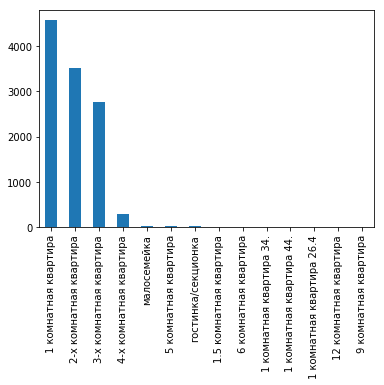

In [187]:
data_flats['Тип'].value_counts().plot(kind='bar')

**Убираем текст из столбцов где должны быть только числа**

In [188]:
data_flats.head()

,url,Адрес,Балкон,Вторичное жилье,Высота потолков,Год постройки,Дата сдачи,Дом(cтроение),Жилая,Застройщик,...,Площадь участка,Продажа,Санузел,Создано,Стадия строительства,Тип,Торг,Цена,Этаж/этажей в доме,Этажей
0,https://kvadrat64.ru/sellflat-499534.html,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",лоджия,NaN,"потолок 2,8 м",NaN,2017 год постройки,дом монолитно-каркасный,44.29,Союз-С,...,NaN,чистая продажа,2 санузла,04-07-2018,дом сдан,3-х комнатная квартира,NaN,5 000 000,этаж 6/18,NaN
1,https://kvadrat64.ru/sellflat-499537.html,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",лоджия,NaN,"потолок 2,8 м",NaN,2017 год постройки,дом монолитно-каркасный,44.29,Союз-С,...,NaN,чистая продажа,2 санузла,04-07-2018,дом сдан,3-х комнатная квартира,NaN,4 250 000,этаж 6/18,NaN
2,https://kvadrat64.ru/sellflat-495453.html,"в ЖК «Крылья», ул. Им Н. Г. Чернышевского, 137...",2 лоджии,NaN,"потолок 2,8 м",NaN,2017 год постройки,дом каркасно-монолитный,57.6,Союз-С,...,NaN,чистая продажа,2 санузла,07-06-2018,дом сдан,4-х комнатная квартира,NaN,4 860 000,этаж 4/18,NaN
3,https://kvadrat64.ru/sellflat-548321.html,"ул. Железнодорожная, 17, ФРУНЗЕНСКИЙ, Саратов",есть балкон,2001 год постройки,NaN,NaN,NaN,дом кирпичный,23,NaN,...,NaN,чистая продажа,NaN,30-06-2019,NaN,1 комнатная квартира,разумный торг,2 100 000,этаж 6/7,NaN
4,https://kvadrat64.ru/sellflat-543709.html,"ул. Большая Садовая,, 160/80, КИРОВСКИЙ, Сарат...",лоджия,NaN,NaN,NaN,NaN,дом кирпичный,18,NaN,...,NaN,NaN,санузел совмещенный,15-05-2019,NaN,1 комнатная квартира,разумный торг,1 550 000,этаж 2/9,NaN


In [189]:
# Очисить значения столбцов 'Площадь', 'Жилая', 'Кухня', 'Цена', 'Высота потолков', 'Этаж/этажей в доме' 
# 'Вторичное жилье', 'Год постройки', 'Дата сдачи' от текста

def parse_area(area_string):
    area_pattern = r'\d+\.\d+'
    area_string = str(area_string)
    match = re.search(area_pattern, area_string)
    return float(match[0]) if match else 0.0

def parse_price(price_string):
    price_pattern = r'\d+'
    price_string = str(price_string)
    match = re.search(price_pattern, price_string.replace(' ', '')) 
    return float(match[0]) if match else 0.0

def parse_ceiling_height(height_string):
    height_pattern = r'\d+\.\d+'
    height_string = str(height_string).replace(',','.')
    match = re.search(height_pattern, height_string) 
    return float(match[0]) if match else 0.0

def parse_floor(floor_string):
    right_pattern = r'\d+\/\d+'
    floor_pattern = r'\d+'
    floor_string = str(floor_string)
    if re.search(right_pattern, floor_string):
        match = re.findall(floor_pattern, floor_string)
        return int(match[0]) if match else 0
    else:
        return 0
    
def parse_num_of_floors(floor_string):
    right_pattern = r'\d+\/\d+'
    floor_pattern = r'\d+'
    floor_string = str(floor_string)
    if re.search(right_pattern, floor_string):
        match = re.findall(floor_pattern, floor_string)
        return int(match[1]) if match else 0
    else:
        return 0
    
def parse_year(year_string):
    year_pattern = r'\d{4}'
    match = re.search(year_pattern, year_string) 
    return int(match[0]) if match else 0

In [190]:
# Площадь
data_flats['Площадь'] = data_flats['Площадь'].apply(parse_area)
# Жилая
data_flats['Жилая'] = data_flats['Жилая'].apply(parse_area)
# Кухня
data_flats['Кухня'] = data_flats['Кухня'].apply(parse_area)
# Цена
data_flats['Цена'] = data_flats['Цена'].apply(parse_price)
# Высота потолков
data_flats['Высота потолков'] = data_flats['Высота потолков'].apply(parse_ceiling_height)
# Этаж/этажей в доме
data_flats['Этажей'] = data_flats['Этаж/этажей в доме'].apply(parse_floor)
data_flats['Этажей в доме'] = data_flats['Этаж/этажей в доме'].apply(parse_num_of_floors)
# Год - объединяем 'Вторичное жилье', 'Год постройки', 'Дата сдачи'
data_flats['Год'] = data_flats['Вторичное жилье'].apply(str) + data_flats['Год постройки'].apply(str) \
                    + data_flats['Дата сдачи'].apply(str)
data_flats['Год'] = data_flats['Год'].apply(parse_year)

data_flats[['Площадь', 'Жилая', 'Кухня', 'Цена', 'Высота потолков', 'Этажей', 'Этажей в доме', 'Год']].head()

,Площадь,Жилая,Кухня,Цена,Высота потолков,Этажей,Этажей в доме,Год
0,87.6,44.29,11.37,5000000.0,2.8,6,18,2017
1,87.6,44.29,11.37,4250000.0,2.8,6,18,2017
2,112.3,57.60,10.36,4860000.0,2.8,4,18,2017
3,0.0,0.00,0.00,2100000.0,0.0,6,7,2001
4,0.0,0.00,2.55,1550000.0,0.0,2,9,0


**Получить район из адреса**

In [204]:
def parse_district(address_string):
    district_pattern = r'\s[А-Я]+,'
    address_string = str(address_string)
    match = re.search(district_pattern, address_string)
    return match[0].replace(',','').strip() if match else ''

In [205]:
data_flats['Район'] = data_flats['Адрес'].apply(parse_district)
data_flats['Район'].head()

0    ОКТЯБРЬСКИЙ
1    ОКТЯБРЬСКИЙ
2    ОКТЯБРЬСКИЙ
3    ФРУНЗЕНСКИЙ
4      КИРОВСКИЙ
Name: Район, dtype: object

**Оставим только нужные столбцы и поменяем их порядок на более удобный** 

In [206]:
arranged_columns = ['Тип', 'Адрес', 'Район', 'Площадь', 'Жилая', 'Кухня', 'Цена', 'Торг', 
                    'Планировка квартиры', 'Комнаты', 'Санузел', 'Высота потолков', 'Окна', 'Балкон', 
                    'Дом(cтроение)', 'Этаж/этажей в доме', 'Лифт', 'Мусоропровод', 
                    'Стадия строительства', 'Год', 'Застройщик',
                    'Ипотека', 'Продажа', 
                    'Создано', 'Обновлено', 'url']
data_flats = data_flats[arranged_columns]
data_flats.shape

(11224, 26)

In [207]:
data_flats.head()

,Тип,Адрес,Район,Площадь,Жилая,Кухня,Цена,Торг,Планировка квартиры,Комнаты,...,Лифт,Мусоропровод,Стадия строительства,Год,Застройщик,Ипотека,Продажа,Создано,Обновлено,url
0,3-х комнатная квартира,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",ОКТЯБРЬСКИЙ,87.6,44.29,11.37,5000000.0,NaN,NaN,комнаты изолированные,...,есть лифт в доме,NaN,дом сдан,2017,Союз-С,возможна продажа в ипотеку,чистая продажа,04-07-2018,07-07-2019,https://kvadrat64.ru/sellflat-499534.html
1,3-х комнатная квартира,"в ЖК «Крылья», ул. Чернышевского, 137а, ОКТЯБР...",ОКТЯБРЬСКИЙ,87.6,44.29,11.37,4250000.0,NaN,NaN,комнаты изолированные,...,есть лифт в доме,NaN,дом сдан,2017,Союз-С,возможна продажа в ипотеку,чистая продажа,04-07-2018,07-07-2019,https://kvadrat64.ru/sellflat-499537.html
2,4-х комнатная квартира,"в ЖК «Крылья», ул. Им Н. Г. Чернышевского, 137...",ОКТЯБРЬСКИЙ,112.3,57.60,10.36,4860000.0,NaN,NaN,комнаты изолированные,...,есть лифт в доме,NaN,дом сдан,2017,Союз-С,возможна продажа в ипотеку,чистая продажа,07-06-2018,07-07-2019,https://kvadrat64.ru/sellflat-495453.html
3,1 комнатная квартира,"ул. Железнодорожная, 17, ФРУНЗЕНСКИЙ, Саратов",ФРУНЗЕНСКИЙ,0.0,0.00,0.00,2100000.0,разумный торг,NaN,NaN,...,NaN,NaN,NaN,2001,NaN,возможна продажа в ипотеку,чистая продажа,30-06-2019,07-07-2019,https://kvadrat64.ru/sellflat-548321.html
4,1 комнатная квартира,"ул. Большая Садовая,, 160/80, КИРОВСКИЙ, Сарат...",КИРОВСКИЙ,0.0,0.00,2.55,1550000.0,разумный торг,старого типа,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,15-05-2019,07-07-2019,https://kvadrat64.ru/sellflat-543709.html


**Сохраняем итоговый csv-файл**

In [208]:
data_flats.to_csv('data_flats.csv', sep=';', index = None, header=True)